In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
from keras.layers import Input, Flatten, Dense,Dropout, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Activation 
from keras.models import Model
from keras import objectives
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras import applications

Using TensorFlow backend.


In [3]:
flowers = [flower for flower in os.listdir('flowers/')]

In [4]:
flowers

['tulip', 'dandelion', 'daisy', 'rose', 'sunflower']

In [5]:
def load(flower):
    path_to_data = 'flowers/'+flower+'/'
    files = [file for file in os.listdir(path_to_data)]
    images = [cv2.imread(path_to_data + file) for file in files]
    images = [cv2.resize(img, (64, 64)) for img in images if img is not None]
    print('number of images of type {}:'.format(flower), len(images))
    labels = [flower]*len(images)
    return images, labels

In [6]:
data, labels= [], []
for i in tqdm(flowers):
    imgs = load(i)
    data += imgs[0] 
    labels += imgs[1]

number of images of type tulip: 984
number of images of type dandelion: 1052
number of images of type daisy: 769
number of images of type rose: 784
number of images of type sunflower: 734



In [7]:
data = np.array(data,dtype='float64') / 255.0

In [8]:
labels = pd.Series(labels).astype('category').cat.codes.values
labels = np.array(labels)
labels = to_categorical(labels, num_classes=5)
print(data.shape, labels.shape)

(4323, 64, 64, 3) (4323, 5)


In [0]:
train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state=1)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=1)

In [41]:
train_x.shape, val_x.shape, test_x.shape

((3124, 64, 64, 3), (3124, 5))

In [0]:
EPOCHS = 100
BS = 64
INIT_LR = 1e-3

In [0]:
image_w, image_h = 64,64
loaded_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

last = loaded_model.output
x = Flatten()(last)
x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
preds = Dense(5, activation='softmax')(x)

revised_model = Model(loaded_model.input, preds)
# revised_Model.summary()
revised_model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

for layer in loaded_model.layers:
    layer.trainable = True

In [58]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

H = revised_model.fit_generator(aug.flow(train_x, train_y, batch_size=BS), validation_data=(val_x,val_y),
                        steps_per_epoch=len(train_x) // BS, epochs=EPOCHS,
                        callbacks = [EarlyStopping(monitor='val_loss',patience = 5)], verbose=1,shuffle=True)

Epoch 1/100
48/48 [==============================] - 12s 242ms/step - loss: 3.4687 - acc: 0.3053 - val_loss: 1.7235 - val_acc: 0.4828
Epoch 2/100
48/48 [==============================] - 9s 190ms/step - loss: 1.5570 - acc: 0.4248 - val_loss: 1.3133 - val_acc: 0.5201
Epoch 3/100
48/48 [==============================] - 9s 191ms/step - loss: 1.3232 - acc: 0.4600 - val_loss: 1.2827 - val_acc: 0.4885
Epoch 4/100
48/48 [==============================] - 9s 190ms/step - loss: 1.2570 - acc: 0.4881 - val_loss: 1.1719 - val_acc: 0.5259
Epoch 5/100
48/48 [==============================] - 9s 190ms/step - loss: 1.1912 - acc: 0.5295 - val_loss: 1.1380 - val_acc: 0.5517
Epoch 6/100
48/48 [==============================] - 9s 190ms/step - loss: 1.1448 - acc: 0.5367 - val_loss: 1.2143 - val_acc: 0.4971
Epoch 7/100
48/48 [==============================] - 9s 190ms/step - loss: 1.1724 - acc: 0.5220 - val_loss: 0.9959 - val_acc: 0.6178
Epoch 8/100
48/48 [==============================] - 9s 190ms/step -

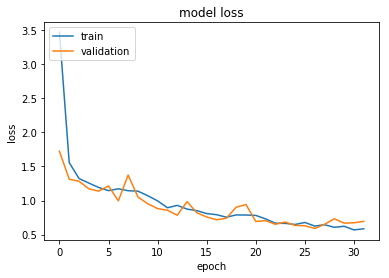

In [59]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()    

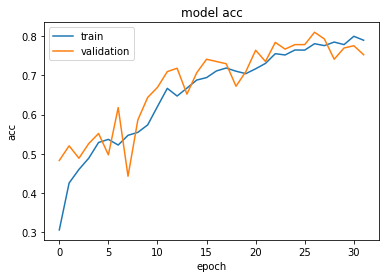

In [61]:
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()    

In [0]:
predictions = revised_model.predict(test_x)

In [63]:
acc = sum([np.argmax(test_y[i])==np.argmax(predictions[i]) for i in range(868)])/868
acc

0.7741935483870968